In [2]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pytesseract import Output

In [67]:
#Code to display results of different thresholding tests
#write_img to write the images to the disk, set to False by default
def thresholding_tests(input_img,write_img=False):
    input_path = 'sample_images/source/'+input_img+'.png'
    img = cv2.imread(input_path,0)
    ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    ret4,th4 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    titles = ['Original Image', 'Global Thresholding (v = 127)',
                'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding',"Otsu's Thresholding"]
    images = [img, th1, th2, th3,th4]
    if (write_img == True):
        cv2.imwrite('sample_images/'+input_img+'_Global_Thresholding(v=127).png',th1)
        cv2.imwrite('sample_images/'+input_img+'_Adaptive_Mean_Thresholding.png',th2)
        cv2.imwrite('sample_images/'+input_img+'_Adaptive_Gaussian.png',th3)
        cv2.imwrite('sample_images/'+input_img+'Otsus_Thresholding.png',th4)
    fig,ax= plt.subplots(figsize=(20,5))
    for i in range(5):

        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

#Code to display results of different brightness and contrast tests
#write_img to write the images to the disk, set to False by default
def brightness_contrast_tests(input_img,write_img=False):
    input_path = 'sample_images/source/'+input_img+'.png'
    img = cv2.imread(input_path,0)
    hist1 = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hist2 = clahe.apply(img)
    bright_img = cv2.convertScaleAbs(img, alpha=2, beta=75)
    images = [hist1,hist2,bright_img]
    if (write_img == True):
        cv2.imwrite('sample_images/'+input_img+'_Histogram_Eq.png',hist1)
        cv2.imwrite('sample_images/'+input_img+'_CHALE_Histogram_Eq.png',hist2)
        cv2.imwrite('sample_images/'+input_img+'_Brightness_up.png',bright_img)
    fig,ax= plt.subplots(figsize=(20,10))
    titles = ['Histogram Equalization','CHALE Histogram Equalization','Increase Brightness']
    for i in range(3):

        plt.subplot(1,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

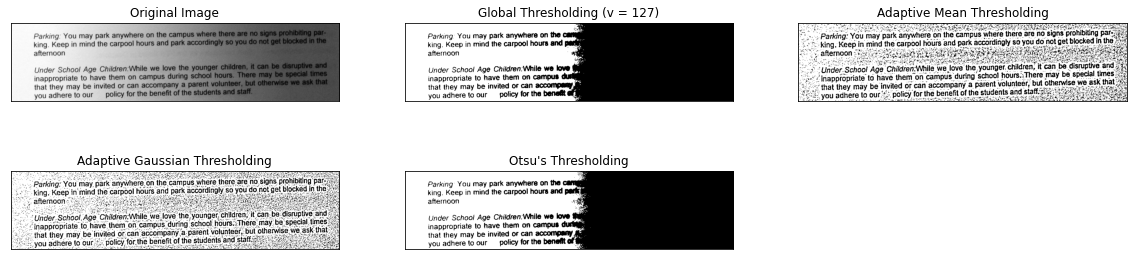

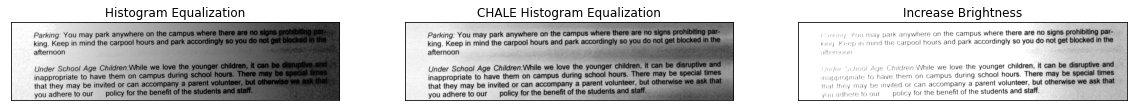

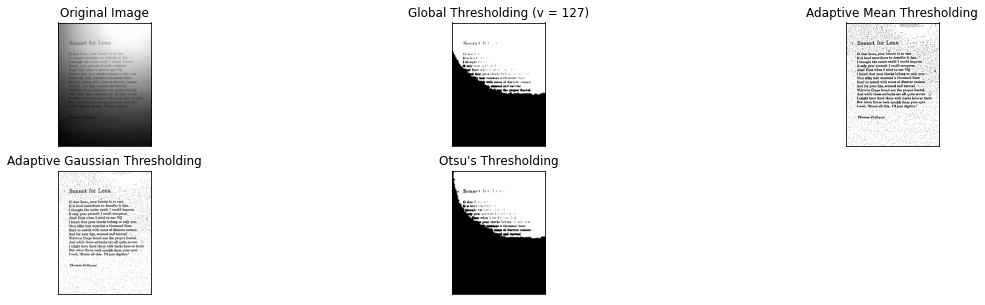

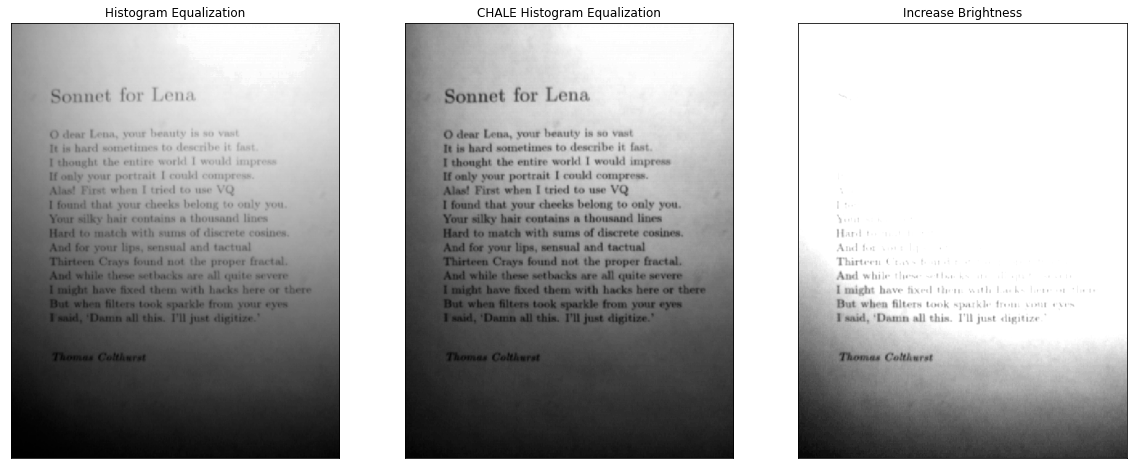

In [68]:
thresholding_tests('sample01',True)
brightness_contrast_tests('sample01',True)
thresholding_tests('sample02',True)
brightness_contrast_tests('sample02',True)

In [16]:
#Dvides an image into 2 based on global thresholding
#Returns the 2 cropped images as an array
#write_images option to write the median filtered image and split images to disk
def split_image(input_img, write_images=True):
    input_path = 'sample_images/source/'+input_img+'.png'
    img = cv2.imread(input_path,0)
    #Global Thresholding 
    ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #Huge median filter to estimate black and white halves
    median = cv2.medianBlur(th1,75)
    rows,cols = median.shape
    #Finding pixel at boundary of black and white image
    sum=0
    for i in range(rows):
        first_px_value = int(median[i,0])
        for j in range(cols):
            current_px_value = int(median[i,j])
            diff = abs(first_px_value-current_px_value)
            if(diff==255):
                margin=j
                sum+=margin
                break
    bound = int(sum/rows)
    #Array slicing to crop image
    crop_img_1 = img[0:rows,0:0+bound]
    crop_img_2 = img[0:rows, bound:cols]
    if (write_images==True):
        cv2.imwrite('sample_images/'+input_img+'_median.png',median)
        cv2.imwrite('sample_images/'+input_img+'_crop1.png',crop_img_1)
        cv2.imwrite('sample_images/'+input_img+'_crop2.png',crop_img_2)
    return ([crop_img_1,crop_img_2])

#Adjust image brightness by splitting the image and increasing brightness of each part separately
def adjust_brightness(input_img,output_img):
    images = split_image(input_img)
    input_path = 'sample_images/'+input_img+'.png'
    output_path = 'sample_images/'+output_img+'.png'  
    adjusted =[]
    #Separately increasing brightness
    for img in images:
        cols, rows = img.shape
        #Finding average brightness of the image
        brightness = np.sum(img) / (255 * cols * rows)
        #Ratio to scale the image brightness by
        minimum_brightness = 0.8
        alpha = brightness / minimum_brightness
        bright_img = cv2.convertScaleAbs(img, alpha = alpha, beta = 255 * (1 - alpha))

        ratio = brightness / minimum_brightness
        if ratio >= 1:
            adjusted.append(img)

        else:
            img =cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)
            adjusted.append(img)
    #Rejoining the images
    vis = np.concatenate((adjusted[0], adjusted[1]), axis=1)  
    cv2.imwrite(output_path,vis)
    return

#Drawing all bounding boxes on the image
def draw_bbox_all(input_img,output_img):
    input_path = 'sample_images/'+input_img+'.png'
    output_path = 'sample_images/'+output_img+'_all.png'
    img = cv2.imread(input_path)
    d = pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes = len(d['level'])
    for i in range(n_boxes):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(output_path,img)
    return

#Drawing bounding boxes which only fit certain conditions
def draw_bbox_filtered(input_img,output_img, conf_level=70):
    input_path = 'sample_images/'+input_img+'.png'
    output_path = 'sample_images/'+output_img+'_filtered.png'
    img = cv2.imread(input_path)
    d = pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes = len(d['level'])
    for i in range(n_boxes):
        #Confidence over 70% and not blank text.
        if (int(d['conf'][i]) > conf_level) and (d['text'][i]!= ''):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

    cv2.imwrite(output_path,img)
    return
#Displaying the text with the same conditions as above
def print_text(input_img, conf_level=70):
    input_path = 'sample_images/'+input_img+'.png'
    img = cv2.imread(input_path)
    d = pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes = len(d['level'])
    text = ''
    for i in range(n_boxes):
        #Confidence over 70% and not blank text.
        if (int(d['conf'][i]) > conf_level) and (d['text'][i]!= ''):
            text+=d['text'][i]+' '
    print(text)

In [17]:
adjust_brightness('sample01','sample01_processed')
draw_bbox_all('sample01_processed','sample01_bbox_processed')
draw_bbox_filtered('sample01_processed','sample01_bbox_processed')
print_text('sample01_processed')

Parking: You may park anywhere on the campus where there are no signs prohibiting par- king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the afternoon Under School Age Children:While we love the younger children, it can be disruptive and inappropriate to have them on campus during school hours. There may be special times that they may be invited or can accompany a parent volunteer, but otherwise we ask that you adhere to our policy for the benefit of the students and staff. 


In [18]:
#Dvides an image into 2 based on global thresholding
#Returns the 2 cropped images as an array
#Option to write the median filtered image and split images to disk
def split_image_2(input_img, write_images=True):
    input_path = 'sample_images/'+input_img+'.png'
    img = cv2.imread(input_path,0)
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE) 
    #Global Thresholding 
    ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #Huge median filter to estimate black and white halves
    median = cv2.medianBlur(th1,75)
    rows,cols = median.shape
    #Estimating boundary of black and white image
    sum=0
    for i in range(rows):
        first_px_value = int(median[i,0])
        for j in range(cols):
            current_px_value = int(median[i,j])
            diff = abs(first_px_value-current_px_value)
            if(diff==255):
                margin=j
                sum+=margin
                break
    bound = int(sum/rows)
    #Array slicing to crop image
    crop_img_1 = img[0:rows,0:0+bound]
    crop_img_2 = img[0:rows, bound:cols]
    if (write_images==True):
        cv2.imwrite('sample_images/'+input_img+'_median.png',median)
        cv2.imwrite('sample_images/'+input_img+'_crop1.png',crop_img_1)
        cv2.imwrite('sample_images/'+input_img+'_crop2.png',crop_img_2)
    return ([crop_img_1,crop_img_2])

#Adjust image brightness by splitting the image and increasing brightness of each part separately
def adjust_brightness_2(input_img,output_img):
    images = split_image_2(input_img)
    input_path = 'sample_images/'+input_img+'.png'
    output_path = 'sample_images/'+output_img+'.png'  
    print()
    adjusted =[]
    #Separately increasing brightness
    for img in images:
        cols, rows = img.shape
        #Finding average brightness of the image
        brightness = np.sum(img) / (255 * cols * rows)
        #Ratio to scale the image brightness by
        minimum_brightness = 0.95
        alpha = brightness / minimum_brightness
        bright_img = cv2.convertScaleAbs(img, alpha = alpha, beta = 255 * (1 - alpha))
        ratio = brightness / minimum_brightness
        if ratio >= 1:
            adjusted.append(img)

        else:
            img =cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)
            adjusted.append(img)
    
    
    img = np.concatenate((adjusted[0], adjusted[1]), axis=1) 
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE) 
    cv2.imwrite(output_path,img)
    return


In [19]:
img = cv2.imread('sample_images/source/sample02_crop.png',0)
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(12,12))
hist2 = clahe.apply(img)
cv2.imwrite('sample_images/sample02_crop_CHALE.png',hist2)

True

In [22]:
adjust_brightness_2('sample02_crop_CHALE','sample02_crop_CHALE_processed')
draw_bbox_filtered('sample02_crop_CHALE_processed','sample02_crop_CHALE_processed_bbox',)
print_text('sample02_crop_CHALE_processed',-1)


Sonnet for Lena j . © dear Lena, your beauty is so vast It is hard sometimes to describe it fast. I thought the entire world | would impress If only your portrait I could compress. Alas! First when I tried to use VQ I found that your cheeks belong to only you. Your silky hair contains a thousand lines Hard to match with sums of discrete cosines. And for your lips, sensual and tactual Thirteen Crays found not the proper fractal. And while these setbacks are all quite severe I might have fixed them with hacks here or there But when filters took sparkle from your eyes: Hsaid, ‘Damn all this. I'll just digitize.” : Thomas Colthurst }   a Fi 


In [23]:
print(pytesseract.image_to_data(Image.open('sample_images/sample02_crop_CHALE_processed.png')))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	478	507	-1	
2	1	1	0	0	0	3	4	262	30	-1	
3	1	1	1	0	0	3	4	262	30	-1	
4	1	1	1	1	0	3	4	262	30	-1	
5	1	1	1	1	1	3	5	110	29	96	Sonnet
5	1	1	1	1	2	129	4	42	26	96	for
5	1	1	1	1	3	187	4	78	26	95	Lena
2	1	2	0	0	0	0	59	478	371	-1	
3	1	2	1	0	0	0	59	208	17	-1	
4	1	2	1	1	0	0	59	208	17	-1	
5	1	2	1	1	1	0	59	4	17	79	j
5	1	2	1	1	2	205	67	3	3	35	.
3	1	2	2	0	0	0	77	343	22	-1	
4	1	2	2	1	0	0	77	343	22	-1	
5	1	2	2	1	1	0	79	15	18	93	©
5	1	2	2	1	2	23	73	45	35	96	dear
5	1	2	2	1	3	75	73	51	35	96	Lena,
5	1	2	2	1	4	137	73	38	35	96	your
5	1	2	2	1	5	186	73	57	35	96	beauty
5	1	2	2	1	6	253	73	17	35	95	is
5	1	2	2	1	7	280	73	15	35	72	so
5	1	2	2	1	8	306	73	37	35	95	vast
3	1	2	3	0	0	3	102	372	21	-1	
4	1	2	3	1	0	3	102	372	21	-1	
5	1	2	3	1	1	0	98	18	32	93	It
5	1	2	3	1	2	26	98	17	32	93	is
5	1	2	3	1	3	50	98	41	32	94	hard
5	1	2	3	1	4	98	102	277	21	96	sometimes
5	1	2	3	1	5	202	98	20	32	96	to
5	1	2	3	1	6	229	98	75	32	95	describe
5	1	